# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


In [1]:
from ema_workbench import (Model, Policy, RealParameter, ScalarOutcome, perform_experiments) # Policy import toegevoegd
from lakemodel_function import lake_problem #andere importfuctie toegevoegd

model = Model('LakeModel', function=lake_problem)

model.uncertainties = [RealParameter("mean", 0.01, 0.05),
                       RealParameter("stdev", 0.001, 0.005),
                       RealParameter("b", 0.1, 0.45),
                       RealParameter("q", 2, 4.5),
                       RealParameter("delta", 0.93, 0.99)]

model.levers = [RealParameter((str('l')+str(i)), 0, 0.1) for i in range(100)]# Voor iedere tijdstap een andere value --- Met str(l)
# Q&A example: model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in range(100)]

model.outcomes = [ScalarOutcome('max_P'), #alle vier outcomes uit de py file
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

from ema_workbench import (MultiprocessingEvaluator, ema_logging)
ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=10)
experiments, outcomes = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [2]:
experiments = experiments.drop([experiments.columns[i] for i in range(5, 105)], axis='columns')

In [3]:
import pandas as pd
import numpy as np
outcomes = pd.DataFrame(outcomes)

outcomes_interest = outcomes['reliability'] <= np.percentile(outcomes['reliability'],10)

In [4]:
from ema_workbench.analysis import prim

prim_alg = prim.Prim(experiments, outcomes_interest, threshold=0.75, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 1000 cases of interest
[MainProcess/INFO] mean: 0.9345454545454546, mass: 0.055, coverage: 0.514, density: 0.9345454545454546 restricted_dimensions: 3


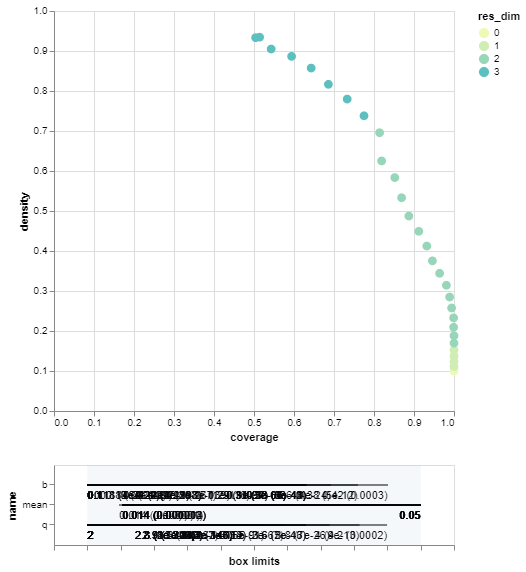

In [5]:
box1.inspect_tradeoff()

**Interpretatie:**
Iedere run komt een andere grafiek door wisselende random sampling en policy, maar in deze run is PRIM-iteratie 24 gekozen om verder te onderzoeken. Deze iteratie heeft een density hoger dan 0,8 en coverage van 0,64. 23 was ook density >0,8, maar richting de volgende iteratie steeg de density sneller (+0,6) dan coverage af nam (-0,5) dus dat leidde de afweging voor iteratie 24.
Er zijn drie variabelen gebruikt om de box te omkaderen, dus de interpreteerbaarheid is goed

coverage       0.643
density     0.857333
id                24
mass           0.075
mean        0.857333
res_dim            3
Name: 24, dtype: object

        box 24                                           
           min       max                        qp values
b     0.100107  0.197202  [-1.0, 1.8070966713894285e-229]
q     2.001223  2.806876  [-1.0, 1.0487110303936962e-219]
mean  0.014179  0.049995   [3.6525534271705705e-06, -1.0]



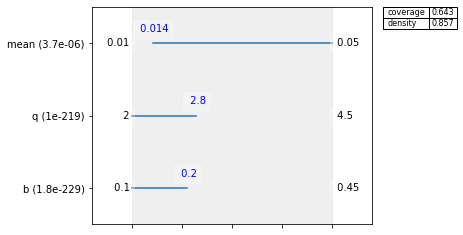

In [6]:
import matplotlib.pyplot as plt

box1.inspect(24, )
box1.inspect(24, style='graph')
plt.show()

**Interpretatie:**
Alle drie variabelen zijn significant in hun afbakening. De b en q zijn zelfs vrij extreem significant. Deze iteratie is dus goed genoeg om mee door te werken.

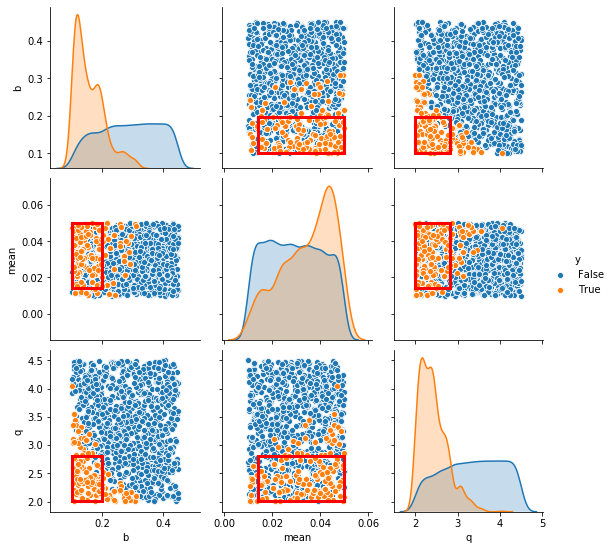

In [7]:
box1.select(24)
fig = box1.show_pairs_scatter()
plt.show()

**Interpretatie:** Zoals ook al uitgedrukt in de beschrijvende statistieken, laten deze grafieken duidelijk zien dat een lage B en Q en hoge mean zorgen voor grote kans op outcome of interest (in dit geval lage betrouwbaarheid). 

In [8]:
box2 = prim_alg.find_box()

[MainProcess/INFO] 9250 points remaining, containing 357 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.3235294117647059, returning dump box


**Interpretatie:** Geen tweede box met hoge fractie interesante cases

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

[MainProcess/INFO] model dropped from analysis because only a single category


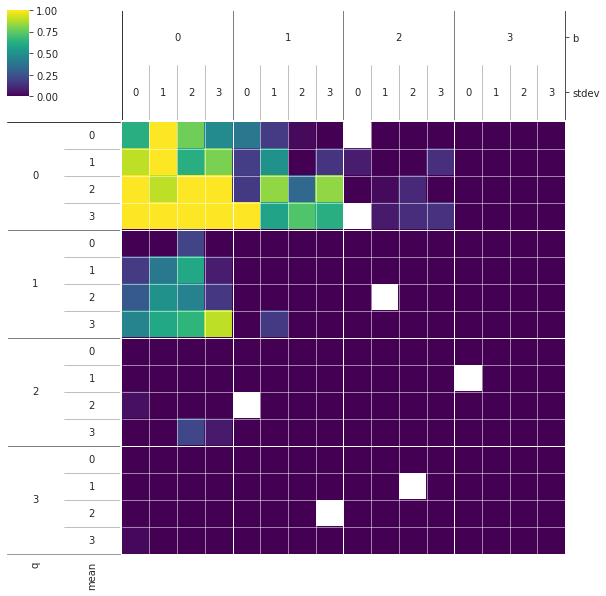

In [9]:
from ema_workbench.analysis import dimensional_stacking

outcomes_interest = outcomes['reliability'] <= np.percentile(outcomes['reliability'],10)
dimensional_stacking.create_pivot_plot(experiments, outcomes_interest, 2, nbins=4)
plt.show()

**Interpretatie:** Dit bevestigt wederom de resultaten die de PRIM als uitkomst geeft lage b in combinatie met lage q, en hoge mean zorgen voor grotere kans op lage betrouwbaarheid. Hier vooral goed te zien in welke scenario's een hoge mean leidt tot onbetrouwbare uitkomst.

Er zijn een aantal witte vlakken waar onvoldoende data beschikbaar is voor signifiante resultaten.